In [1]:
import os


os.environ['PYTHONHOME'] = r"C:\Users\me\AppData\Local\Programs\Python\Python37"
os.environ['PYTHONPATH'] = r"C:\Users\me\AppData\Local\Programs\Python\Python37\Lib\site-packages"
os.environ['R_HOME'] = r"C:\Program Files\R\R-3.6.3"
os.environ['R_USER'] = r"C:\Users\me\AppData\Local\Programs\Python\Python37\Lib\site-packages\rpy2"

import rpy2
import rpy2.robjects as robjects

pi = robjects.r['pi']

In [2]:
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
import statsmodels.api as sm
from scipy.stats import zscore
import scipy as sp
from numpy import random, linalg
from scipy import sparse, stats
import itertools as it
from sklearn.preprocessing import StandardScaler as scaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
import multiprocessing
import rpy2.robjects as robjects


matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{amssymb}',
    r'\usepackage{amsmath}',
    r'\usepackage{xcolor}',
    r'\renewcommand*\familydefault{\sfdefault}']
matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
matplotlib.rcParams['pgf.preamble'] = [
    r'\usepackage[utf8x]{inputenc}',
    r'\usepackage{amssymb}',
    r'\usepackage[T1]{fontenc}',
    r'\usepackage{amsmath}',
    r'\usepackage{sansmath}']

inv, ax, norm = np.linalg.inv, np.newaxis, np.linalg.norm
randint = np.random.randint


In [3]:
from KmeansHelperAGTT import kmeans_objective,kmeans_updateCenters, kmeans_updateGroups, kmeans_estimateGroups

## Exercise 1. K-means clustering

### Part A: K-means Objective Function

We have coded this in `kmeans_objective`.

### Part B: Updating Centers

We have coded this in `kmeans_updateCenters`.

### Part C: Updating Groups

We have coded this in `kmeans_updateGroups`.

### Part D: Estimating Groups

We have coded this in `kmeans_estimateGroups`.



### Part E: Verifying the Results
We have coded `generateSample` in Python but as the seed is different it results a different sample. To have a comparable result we have run R-script given in the question below. 

In [4]:
data_mixture = robjects.r("""
generateSample = function(N, p, K, meanScale=1, varScale=1) {
  
  # generate random mean vectors
  means = foreach(k=1:K) %do% { meanScale * rnorm(p) }
  # generate random variances
  vars = foreach(k=1:K) %do% {
    varChol = matrix(0, nrow=p, ncol=p)
    varChol[lower.tri(varChol, diag = TRUE)] = varScale * rnorm(p*(p+1)/2)
    varChol
  }
  
  # generate standard normal draws, into p * N matrix
  draws = matrix(rnorm(p*N), nrow=p, ncol=N)
  # generate group memberships
  groups = 1 + as.integer(runif(N, min=0, max=K))
  # location and scale shift according to the mixture components
  for(j in 1:K) {
    draws[,groups == j] = means[[j]] + vars[[j]] %*% draws[,groups == j]
  }
  # return draws and the true group membership
  return(list(draws=t(draws), centers=do.call(rbind, means), groups=groups))
}

# load library
library(foreach)

# set seed
set.seed(400)

# specify model
model = list(N=1000, p=3, K=5, S=1000, meanScale=1, varScale=0.7)

# generate mixture model
data.mixture = generateSample(model$N, model$p, model$K, model$meanScale, model$varScale)
""")


In [5]:
draws=np.asarray(data_mixture.rx2('draws'))
centers=np.asarray(data_mixture.rx2('centers'))
groups=np.asarray(data_mixture.rx2('groups'))-1
data_mixture = {'draws':draws,'centers':centers,'groups':groups}

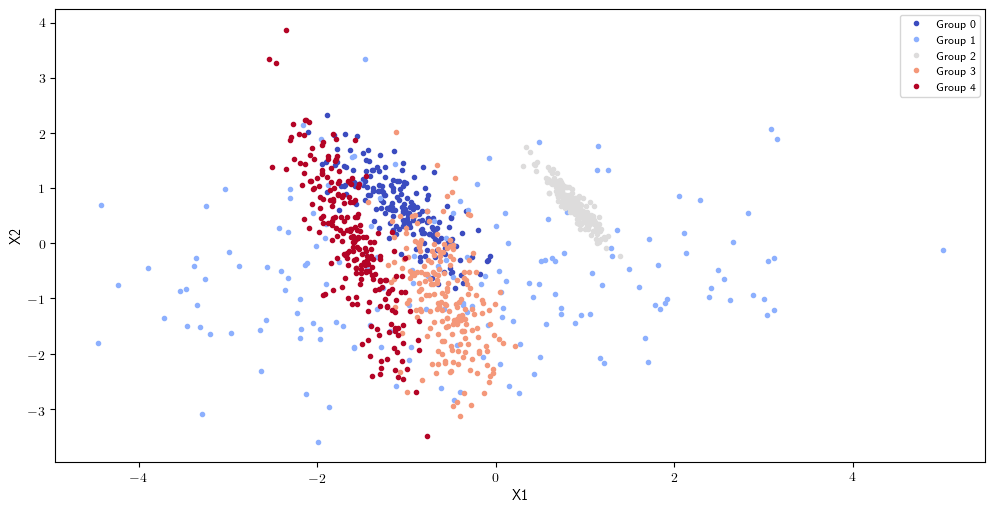

In [6]:
K=5
fig,ax=plt.subplots(figsize=(12,6)  , dpi=100)
label=[]
ax.set_prop_cycle('color',[plt.cm.coolwarm(i) for i in np.linspace(0, 1, K)])

for k in range(K):
    ax.plot(data_mixture['draws'][data_mixture['groups']==k,0],data_mixture['draws'][data_mixture['groups']==k,1],'o',markersize=3)
    label=label+['Group {}'.format(k)]
plt.legend(label,fontsize=8)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [8]:
S=1000
N=1000
data_kmeans_minimum = {'groups':[],'centers':[],'objectives':np.array([1e10,1e10]),'steps':[],'status':[]}

# try multiple initial points and pick the clustering with the minimum objective
for s in range(S):
    est = kmeans_estimateGroups(K = K, initCenters = data_mixture['draws'][random.choice(np.arange(N),size=K),], X = data_mixture['draws'])
    if min(data_kmeans_minimum['objectives']) > min(est['objectives']):
        data_kmeans_minimum = est
        

# print the best solution
data_kmeans_minimum

C:\Users\tugce\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\tugce\anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


{'groups': array([4., 2., 1., 0., 1., 3., 4., 0., 4., 2., 3., 1., 2., 2., 4., 0., 2.,
        3., 4., 0., 0., 4., 4., 1., 2., 4., 3., 0., 0., 4., 3., 3., 0., 2.,
        4., 0., 0., 3., 3., 0., 0., 0., 3., 0., 1., 0., 0., 2., 4., 0., 3.,
        1., 2., 0., 2., 0., 0., 1., 2., 1., 2., 3., 0., 4., 1., 3., 3., 3.,
        3., 2., 2., 2., 2., 3., 0., 4., 0., 0., 2., 3., 4., 2., 0., 1., 2.,
        0., 4., 3., 4., 0., 2., 4., 3., 0., 3., 0., 2., 4., 0., 0., 0., 2.,
        4., 2., 3., 0., 0., 2., 4., 2., 0., 4., 3., 0., 2., 2., 0., 2., 2.,
        0., 0., 2., 3., 3., 2., 3., 3., 0., 3., 2., 2., 3., 2., 3., 2., 3.,
        4., 3., 2., 1., 3., 2., 4., 4., 0., 2., 2., 3., 0., 2., 2., 3., 2.,
        1., 0., 3., 1., 2., 2., 0., 3., 1., 4., 2., 3., 2., 1., 2., 0., 3.,
        0., 3., 3., 2., 2., 4., 3., 3., 0., 4., 0., 4., 0., 4., 2., 0., 0.,
        0., 0., 0., 0., 3., 3., 0., 2., 4., 2., 3., 0., 0., 3., 3., 1., 0.,
        3., 4., 2., 4., 2., 3., 1., 0., 4., 2., 4., 4., 2., 3., 0., 4., 2.,
  

In [9]:
{'estimated':data_kmeans_minimum['centers'], 'true':data_mixture['centers']}


{'estimated': array([[-1.1466349 ,  0.50331819,  1.19603388],
        [ 1.22676688, -1.07621635, -2.84325581],
        [ 0.84033497,  0.71676427,  0.02472215],
        [-0.77099811, -1.47879997, -0.685758  ],
        [-1.85618843,  0.27888361, -1.3941622 ]]),
 'true': array([[-1.03654875,  0.61528331,  1.47293261],
        [-0.68268726, -0.60183857, -1.35260973],
        [ 0.86073866,  0.72037049,  0.10785322],
        [-0.57455118, -0.90184718,  0.08928709],
        [-1.59379572, -0.08685912, -1.17092161]])}

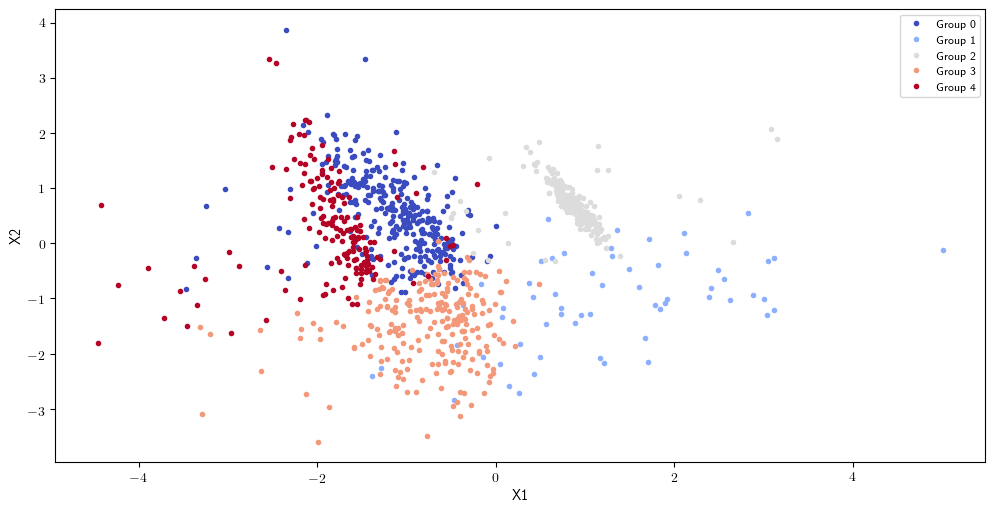

In [10]:
fig,ax=plt.subplots(figsize=(12,6)  , dpi=100)
label=[]
ax.set_prop_cycle('color',[plt.cm.coolwarm(i) for i in np.linspace(0, 1, K)])

for k in range(K):
    ax.plot(data_mixture['draws'][data_kmeans_minimum['groups']==k,0],data_mixture['draws'][data_kmeans_minimum['groups']==k,1],'o',markersize=3)
    label=label+['Group {}'.format(k)]
plt.legend(label,fontsize=8)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()